In [1]:
from fastai.vision.all import *
from pathlib import Path
from torch import nn

In [2]:
image_size_before_crop = 256
image_size_after_crop = 224

In [3]:
item_tfms = [Resize(image_size_before_crop)]

# Batch-level operations (executed on GPU)
batch_tfms = [
    # "layer-agnostic" normalization
    Normalize.from_stats(0.5, 1.0),
    # Bunch of random transforms
    *aug_transforms(
        do_flip=True,  # Do flips with default probability of 0.5
        flip_vert=True,  # including vertical flip
        max_rotate=0.0,  # no rotation
        max_zoom=0.0,  # no zoom
        max_lighting=0.4,  # color augmentation
        max_warp=0.0,  # no warp
        size=image_size_before_crop  # Then resize to 256x256
    ),
    # Random crop to 224 (it automatically becomes center crop during validation)
    RandomCrop(image_size_after_crop)
]

In [6]:
path = "/data/rcr_evaluation_imagenet"
data = ImageDataLoaders.from_folder(path, valid='val', num_workers=12)
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_items=get_image_files, 
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=parent_label,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms
                  ) 
dls = dblock.dataloaders(path, bs=1024, num_workers=20)

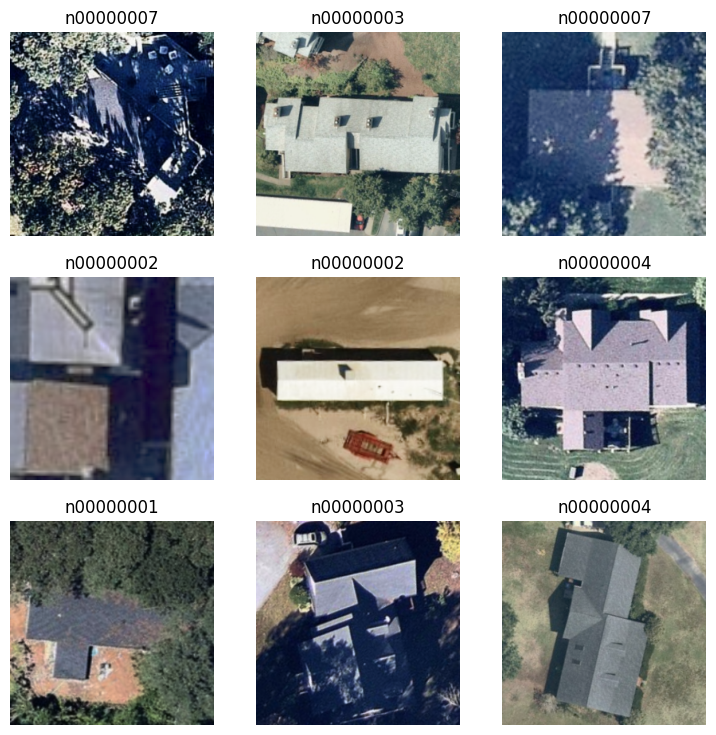

In [7]:
dls.show_batch()


In [8]:
from train_pl import ImageClassifier
from omegaconf import OmegaConf
from dinov2.configs import dinov2_default_config
from dinov2.eval.setup import build_model_for_eval
from dinov2.eval.linear import create_linear_input


In [9]:
default_cfg = OmegaConf.create(dinov2_default_config)
cfg = OmegaConf.load("30epochswd01_config.yaml")

dino = build_model_for_eval(cfg, "30epochswd01_87499.pth", cuda=False)
model = ImageClassifier(dino, len(dls.vocab))

In [10]:
learn = Learner(dls, model, loss_func=F.cross_entropy, opt_func=Adam, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (log) that exists in the learner. Use `self.learn.log` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


SuggestedLRs(valley=0.00019054606673307717)

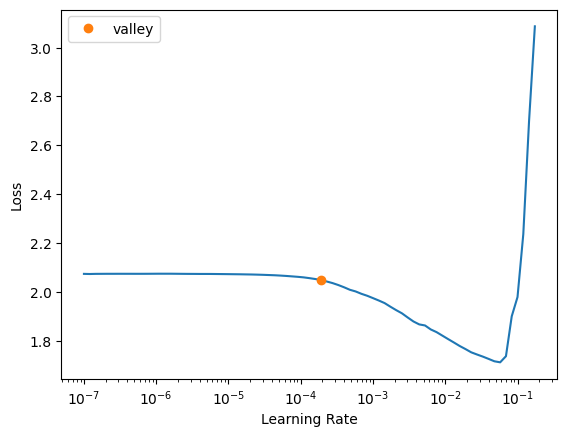

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(50, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.688490,1.456496,0.490348,03:39
1,1.370050,1.120793,0.562945,03:40
2,1.207437,1.062702,0.581581,03:41
3,1.123133,1.028206,0.589063,03:40
4,1.079764,1.026785,0.583528,03:40
5,1.055201,1.008215,0.595405,03:40
6,1.044363,1.006796,0.594348,03:41
7,1.034372,1.007571,0.594821,03:40
8,1.023448,0.997612,0.595989,03:41
9,1.021883,1.010985,0.596323,03:41


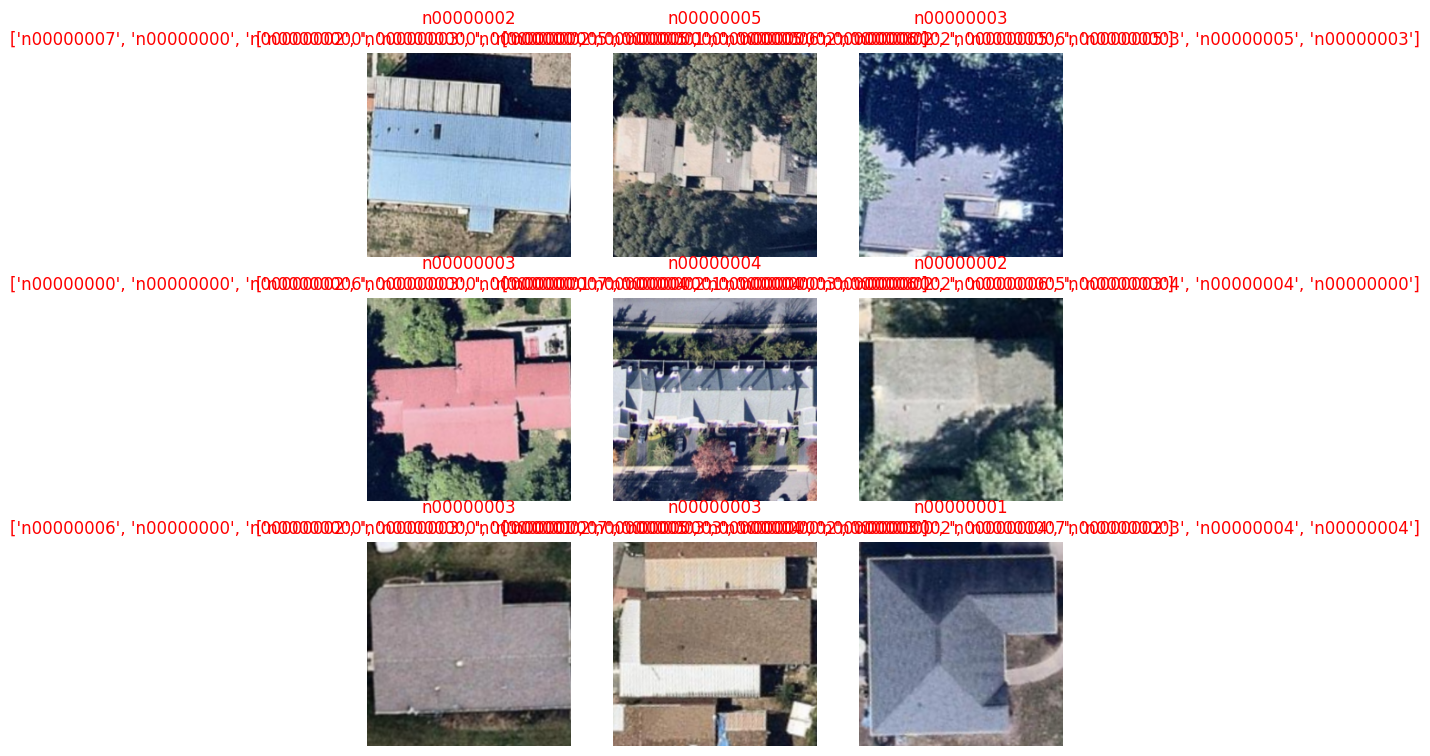

In [19]:
learn.show_results()

In [18]:
len(r)

2